In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
from PIL import Image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
def load_and_preprocess_data():
    train_dta = pd.read_csv('/Users/jegathsubhash/Downloads/fer_org .csv')
    class_dta = pd.read_csv('/Users/jegathsubhash/Downloads/fer_test.csv')

    emo_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                'unknown', 'NF']

    data_sam_cl = len(train_dta)
    imasize1 = 48
    imasize2 = 48

    clsses_O = np.array(class_dta[emo_classes])
    display = np.zeros((data_sam_cl, imasize1, imasize2, 1))
    for i in range(data_sam_cl):
        display[i] = np.fromstring(train_dta['pixels'][i], dtype=int, sep=' ').reshape((imasize2, imasize1, 1))

    return display, clsses_O

In [13]:
def dtacleaning_andnormalization(display, clsses_O):
    emo_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                'unknown', 'NF']

    recertxi = clsses_O.argmax(axis=-1)
    recert = recertxi < emo_classes.index('unknown')
    display = display[recert]
    clsses_O = clsses_O[recert]

    clsses_O = clsses_O[:, :-2] * 0.1
    clsses_O[:, 0] += clsses_O[:, 7]
    clsses_O = clsses_O[:, :7]

    display = display / 255.0

    return display, clsses_O

In [14]:
def data_splitting(X, y):
    test_size = ceil(len(X) * 0.1)


    training_dta1, testing_dta1, training_dta2, testing_dta2 = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    training_dta1, x_val, training_dta2, y_val = model_selection.train_test_split(training_dta1, training_dta2, test_size=test_size,
                                                                      random_state=42)
    return training_dta1, training_dta2, x_val, y_val, testing_dta1, testing_dta2

In [15]:
def dataugamentation(training_dta1):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(training_dta1)
    return datagen

def visualise_dataugamentation(datagen, training_dta1, training_dta2):
    it = datagen.flow(training_dta1, training_dta2, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
    plt.show()

In [16]:
def my_face_emo_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [17]:
def _acc_loss_plot(history):
    
    sns.set(style="whitegrid")  # Set seaborn style

    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

     # Code for plotting accuracy
    plt.subplot(1, 2, 1)  # Create a subplot for accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='lower right')
    plt.title('Model Train and Validation Accuracy')

# Code for plotting loss
    plt.subplot(1, 2, 2)  # Create a subplot for loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Total Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Training and Validation Loss')

    plt.tight_layout()  # Adjust the layout for better spacing
    plt.show()


In [18]:
def cnn_emo_model(model):
    # Save model architecture as JSON
    model_json = model.to_json()
    with open('MY FACIAL_EMOTION RECORGNITION_MODEL', 'w') as json_file:
        json_file.write(model_json)
        
    # for saving the model
    model.save_weights('MY FACIAL_EMOTION RECORGNITION_MODEL.h5')
    

In [19]:
def loading_trained_model_and_weights():
    # for loading the model
    with open('MY FACIAL_EMOTION RECORGNITION_MODEL', 'r') as json_file:
        loaded_model_json = json_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    
    # for loading the weights
    model.load_weights('MY FACIAL_EMOTION RECORGNITION_MODEL.h5')
    
    # for compiling the model 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    

training_dta1 shape: (28390, 48, 48, 1)
training_dta2 shape: (28390, 7)
testing_dta1 shape: (3549, 48, 48, 1)
testing_dta2 shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0

Epoch 1/50
443/443 [==============================] - 198s 443ms/step - loss: 0.3723 - accuracy: 0.4033 - val_loss: 0.3436 - val_accuracy: 0.5010
Epoch 2/50
443/443 [==============================] - 192s 435ms/step - loss: 0.2969 - accuracy: 0.5771 - val_loss: 0.2572 - val_accuracy: 0.6582
Epoch 3/50
443/443 [==============================] - 193s 437ms/step - loss: 0.2683 - accuracy: 0.6399 - val_loss: 0.2624 - val_accuracy: 0.6607
Epoch 4/50
443/443 [==============================] - 769s 2s/step - loss: 0.2539 - accuracy: 0.6696 - val_loss: 0.2336 - val_accuracy: 0.7101
Epoch 5/50
443/443 [==============================] - 176s 397ms/step - loss: 0.2457 - accuracy: 0.6874 - val_loss: 0.2246 - val_accuracy: 0.7351
Epoch 6/50
443/443 [==============================] - 152s 342ms/step - loss: 0.2390 - accuracy: 0.7059 - val_loss: 0.2222 - val_accuracy: 0.7436
Epoch 7/50
443/443 [==============================] - 967s 2s/step - loss: 0.2344 - accuracy: 0.7185 - val_loss: 0.2224 - val_a

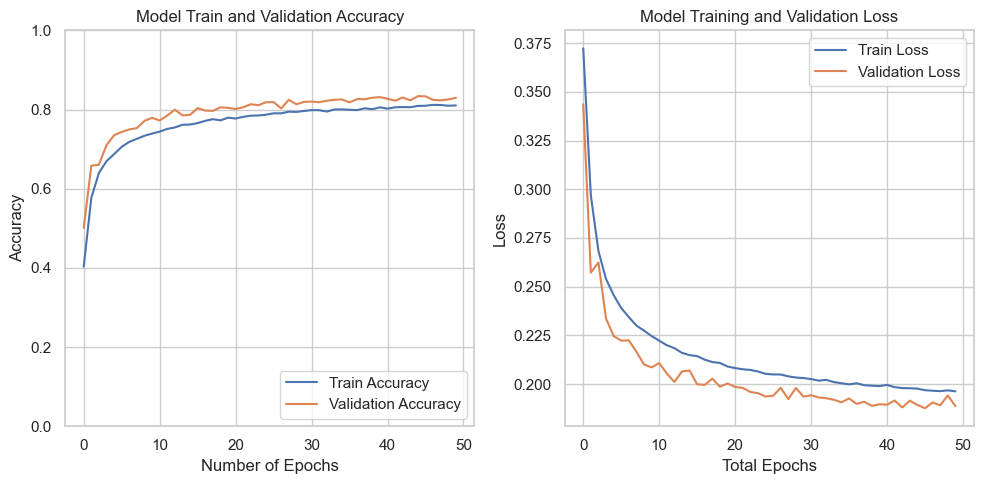

In [20]:
def run_expression_recognition():
    emotion_clsses_O = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    display, clsses_O = load_and_preprocess_data()
    display, clsses_O = dtacleaning_andnormalization(display, clsses_O)
    training_dta1, training_dta2, x_val, y_val, testing_dta1, testing_dta2 = data_splitting(display, clsses_O)
    data_augmenter = dataugamentation(training_dta1)

    num_epochs = 50
    batch_size = 64

    print(f"training_dta1 shape: {training_dta1.shape}")
    print(f"training_dta2 shape: {training_dta2.shape}")
    print(f"testing_dta1 shape: {testing_dta1.shape}")
    print(f"testing_dta2 shape: {testing_dta2.shape}")
    print(f"X_val shape: {x_val.shape}")
    print(f"Y_val shape: {y_val.shape}")

    emotion_model = my_face_emo_model(input_shape=training_dta1[0].shape, num_classes=len(emotion_clsses_O))
    emotion_model.summary()
    emotion_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    training_history = emotion_model.fit(data_augmenter.flow(training_dta1, training_dta2, batch_size=batch_size), epochs=num_epochs,
                                         steps_per_epoch=len(training_dta1) // batch_size,
                                         validation_data=(x_val, y_val), verbose=1)
    testing_data_loss_model, testing_data_acc_model = emotion_model.evaluate(testing_dta1, testing_dta2, batch_size=batch_size)

    _acc_loss_plot(training_history)
    cnn_emo_model(emotion_model)

run_expression_recognition()